In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np

In [ ]:
from scipy.ndimage import rotate

angle = 13

def rotate_and_crop(images, angle):
    rotated_images = []
    for img in images:
        rotated_img = rotate(img.squeeze(), angle, reshape=False)
        center_x, center_y = rotated_img.shape[0] // 2, rotated_img.shape[1] // 2
        cropped_img = rotated_img[center_x - 16:center_x + 16, center_y - 16:center_y + 16]
        rotated_images.append(cropped_img)
    return np.array(rotated_images)




In [ ]:
# Load CIFAR-10 dataset
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from scipy.ndimage import rotate
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

# Select only the 'plane' class images (class index 0 in CIFAR-10)
plane_train_images =train_images[np.where(train_labels == 0)[0]]
plane_test_images = test_images[np.where(test_labels == 0)[0]]

# Apply rotation transformation to the plane images
angle = 13  # Rotation angle in degrees

rotated_plane_train_images = rotate_and_crop(plane_train_images, angle)
rotated_plane_test_images = rotate_and_crop(plane_test_images, angle)


# Normalize pixel values to range [0, 1]
plane_train_images = plane_train_images.astype('float32') / 255.
plane_test_images = plane_test_images.astype('float32') / 255.
rotated_plane_train_images = rotated_plane_train_images.astype('float32') / 255.
rotated_plane_test_images = rotated_plane_test_images.astype('float32') / 255.

# Create rotation angle labels
train_angles = np.full((len(plane_train_images), 1), angle)
test_angles = np.full((len(plane_test_images), 1), angle)

# Concatenate original and rotated images




In [ ]:
import tensorflow as tf

def autoencoder(input_shape):
    # Input layers
    normal_image_input = tf.keras.layers.Input(shape=input_shape, name='normal_image_input')
    rotated_image_input = tf.keras.layers.Input(shape=input_shape, name='rotated_image_input')

    # Encoder for normal image
    x_normal = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(normal_image_input)
    x_normal = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x_normal)
    x_normal = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x_normal)
    x_normal = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x_normal)

    # Encoder for rotated image
    x_rotated = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(rotated_image_input)
    x_rotated = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x_rotated)
    x_rotated = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x_rotated)
    x_rotated = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x_rotated)

    # Concatenate encoded features
    concatenated_features = tf.keras.layers.Concatenate()([x_normal, x_rotated])

    # Decoder
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(concatenated_features)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    outputs = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    # Transformation prediction layer
    global_pooling = tf.keras.layers.GlobalAveragePooling2D()(concatenated_features)
    angle_prediction = tf.keras.layers.Dense(1, activation='linear', name='angle_prediction')(global_pooling)

    # Compile modelDD
    autoencoder_model = tf.keras.Model(inputs=[normal_image_input, rotated_image_input], outputs=[outputs, angle_prediction])
    autoencoder_model.compile(optimizer='adam', loss=['mse', 'mse'], loss_weights=[1.0, 0.5])
    return autoencoder_model

input_shape = (32, 32, 3)
autoencoder_model = autoencoder(input_shape)
autoencoder_model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 normal_image_input (InputL  [(None, 32, 32, 3)]          0         []                            
 ayer)                                                                                            
                                                                                                  
 rotated_image_input (Input  [(None, 32, 32, 3)]          0         []                            
 Layer)                                                                                           
                                                                                                  
 conv2d_7 (Conv2D)           (None, 32, 32, 32)           896       ['normal_image_input[0][0]']  
                                                                                            

In [ ]:
len(train_images)

50000

In [ ]:
len(train_images[0])

32

In [ ]:

len(train_images[1])

32

In [ ]:

autoencoder_model.fit(x=[plane_train_images, rotated_plane_train_images],
                      y=[plane_train_images, train_angles],
                      epochs=10,
                      batch_size=128,
                      shuffle=True)

Epoch 1/10
40/40 [==============================] - 40s 887ms/step - loss: 26.0695 - conv2d_13_loss: 0.0508 - angle_prediction_loss: 52.0374
Epoch 2/10
40/40 [==============================] - 27s 683ms/step - loss: 3.6435 - conv2d_13_loss: 0.0381 - angle_prediction_loss: 7.2108
Epoch 3/10
40/40 [==============================] - 27s 680ms/step - loss: 2.7191 - conv2d_13_loss: 0.0309 - angle_prediction_loss: 5.3762
Epoch 4/10
40/40 [==============================] - 28s 692ms/step - loss: 1.6322 - conv2d_13_loss: 0.0250 - angle_prediction_loss: 3.2142
Epoch 5/10
40/40 [==============================] - 28s 698ms/step - loss: 0.6342 - conv2d_13_loss: 0.0234 - angle_prediction_loss: 1.2215
Epoch 6/10
40/40 [==============================] - 30s 733ms/step - loss: 0.2638 - conv2d_13_loss: 0.0227 - angle_prediction_loss: 0.4822
Epoch 7/10
40/40 [==============================] - 28s 685ms/step - loss: 0.1858 - conv2d_13_loss: 0.0215 - angle_prediction_loss: 0.3285
Epoch 8/10
40/40 [=======

In [ ]:
plane_train_images.shape

(5000, 32, 32, 3)

In [ ]:
rotated_plane_train_images.shape

(5000, 32, 32, 3)

In [ ]:
train_angles.shape

(5000, 1)

In [ ]:
train_angles


array([[13],
       [13],
       [13],
       ...,
       [13],
       [13],
       [13]])

In [ ]:
reconstructed_images, angle_predictions = autoencoder_model.predict([plane_test_images, rotated_plane_test_images])

32/32 [==============================] - 1s 42ms/step


In [ ]:


import matplotlib.pyplot as plt

def plot_reconstructed_images(reconstructed_images):
    # Plot the first 10 reconstructed images
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    axes = axes.flatten()

    for i in range(10):
        axes[i].imshow(reconstructed_images[i].reshape(32, 32), cmap='gray')
        axes[i].axis('off')

    plt.show()

# Example usage:
# Assuming reconstructed_images is a numpy array containing the reconstructed images
# Assuming the first dimension corresponds to the batch size
# plot_reconstructed_images(reconstructed_images)


In [ ]:
angle_predictions[:10]

array([[12.977581],
       [12.474321],
       [13.105673],
       [12.901862],
       [13.528507],
       [12.62752 ],
       [13.178266],
       [13.049372],
       [11.831699],
       [14.009483]], dtype=float32)

In [ ]:
import numpy as np

def calculate_mse(original_images, reconstructed_images, ground_truth_angles, predicted_angles):
    # Calculate MSE for reconstructed images
    reconstructed_mse = np.mean(np.square(original_images - reconstructed_images))

    # Calculate MSE for angle predictions
    angle_mse = np.mean(np.square(ground_truth_angles - predicted_angles))

    # Combine MSE values (e.g., take the sum)
    combined_mse = reconstructed_mse + angle_mse

    # Define threshold (e.g., as a percentage of the combined MSE)

    return combined_mse


In [ ]:
train_angles.shape

(5000, 1)

In [ ]:
angle_predictions.shape

(1000, 1)

In [ ]:
len(train_images)

50000

In [ ]:
len(train_images)

50000

In [ ]:
len(train_images[0])

32

In [ ]:
len(train_labels)

50000

In [ ]:
anomalous_data = train_images[np.where(train_labels != 0)[0]]

In [ ]:
len(plane_train_images)

5000

In [ ]:

len(anomalous_data)

45000

In [ ]:
angle = 13

rotated_anomalous_train_images = rotate_and_crop(anomalous_data, angle)

In [ ]:
rotated_anomalous_train_images = rotated_anomalous_train_images.astype('float32') / 255.

In [ ]:
anomaly_angles = np.full((45000, 1), 13)

In [ ]:
normal_reconstructed_images, normal_angle_predictions = autoencoder_model.predict([plane_train_images, rotated_plane_train_images])
anomalous_reconstructed_images, anomalous_angle_predictions = autoencoder_model.predict([anomalous_data,rotated_anomalous_train_images])

1407/1407 [==============================] - 66s 47ms/step


In [ ]:
normal_angle_predictions[:10]

array([[13.473684],
       [12.887623],
       [13.081071],
       [14.073788],
       [12.535558],
       [12.703937],
       [13.091694],
       [13.082788],
       [12.525716],
       [12.705891]], dtype=float32)

In [ ]:
normal_image_errors = tf.keras.losses.mean_squared_error(plane_train_images, normal_reconstructed_images)
normal_angle_errors = tf.keras.losses.mean_squared_error(train_angles, normal_angle_predictions)

In [ ]:
normal_image_errors.shape

TensorShape([5000, 32, 32])

In [ ]:
normal_errors = [x + y for x, y in zip(normal_image_errors, normal_angle_errors)]

In [ ]:
anomaly_image_errors = tf.keras.losses.mean_squared_error(anomalous_data, anomalous_reconstructed_images)
anomaly_angle_errors = tf.keras.losses.mean_squared_error(anomaly_angles, anomalous_angle_predictions)

In [ ]:
anomalous_errors = [x + y for x, y in zip(anomaly_image_errors, anomaly_angle_errors)]

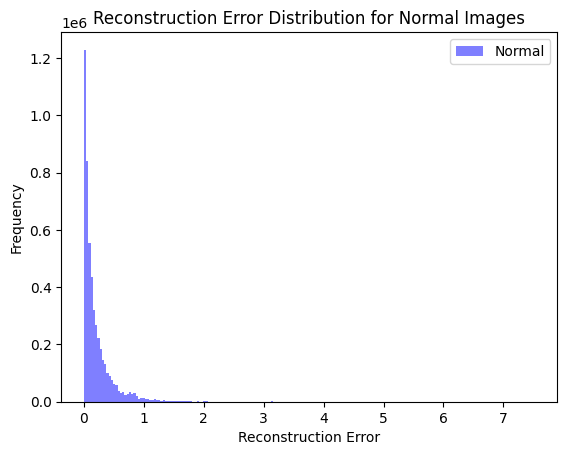

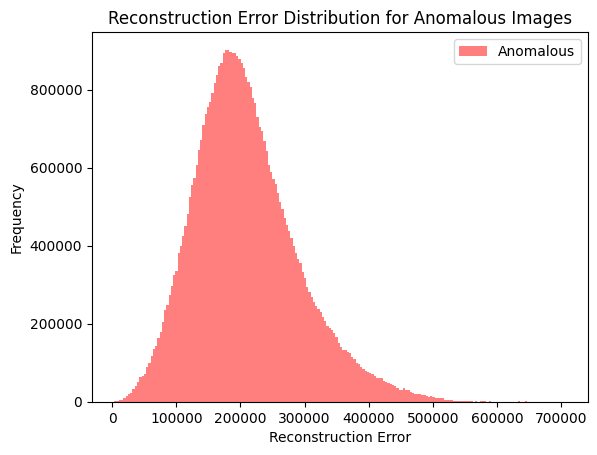

In [ ]:
# Calculate reconstruction errors for normal and anomalous data
normal_errors_np = np.array(normal_errors)
# Set threshold for anomaly detection based on normal data errors
normal_errors_flat = normal_errors_np.flatten()
# Visualize reconstruction errors for normal data
plt.hist(normal_errors_flat, bins=200, color='blue', alpha=0.5, label='Normal')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Reconstruction Error Distribution for Normal Images')
plt.legend()
plt.show()

# Visualize reconstruction errors for anomalous data
anomalous_errors_np = np.array(anomalous_errors)
anomalous_errors_flat = anomalous_errors_np.flatten()
plt.hist(anomalous_errors_flat, bins=200, color='red', alpha=0.5, label='Anomalous')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Reconstruction Error Distribution for Anomalous Images')
plt.legend()
plt.show()

In [ ]:
anomalous_angle_predictions[:10]

array([[479.22833],
       [503.37393],
       [453.2142 ],
       [341.53613],
       [431.47763],
       [488.10803],
       [502.41144],
       [477.81287],
       [580.38007],
       [299.6315 ]], dtype=float32)

In [ ]:
normal_angle_predictions[:10]

array([[13.473684],
       [12.887623],
       [13.081071],
       [14.073788],
       [12.535558],
       [12.703937],
       [13.091694],
       [13.082788],
       [12.525716],
       [12.705891]], dtype=float32)

In [ ]:
normal_errors[0]

<tf.Tensor: shape=(32, 32), dtype=float32, numpy=
array([[0.22483627, 0.22670735, 0.22501597, ..., 0.22517519, 0.22624023,
        0.22449647],
       [0.22463235, 0.22492081, 0.22496676, ..., 0.22773631, 0.23046032,
        0.22754078],
       [0.2247908 , 0.22456805, 0.22444834, ..., 0.22835238, 0.23025325,
        0.2294439 ],
       ...,
       [0.26649797, 0.26933205, 0.26286757, ..., 0.22591205, 0.22662966,
        0.23022076],
       [0.27566743, 0.26430553, 0.2690085 , ..., 0.22633882, 0.22603141,
        0.23788539],
       [0.2811154 , 0.28400186, 0.279589  , ..., 0.238305  , 0.23826395,
        0.2626011 ]], dtype=float32)>

In [ ]:
anomalous_errors[0]

<tf.Tensor: shape=(32, 32), dtype=float32, numpy=
array([[221011.86, 219277.19, 219493.53, ..., 235121.86, 233494.86,
        233082.86],
       [217684.53, 217369.86, 217481.86, ..., 225825.19, 225051.86,
        225759.86],
       [217870.53, 217456.19, 218378.53, ..., 225028.53, 225185.86,
        223545.19],
       ...,
       [244180.53, 238766.53, 239046.86, ..., 233190.86, 218689.19,
        218753.53],
       [237405.53, 232751.86, 235873.86, ..., 238617.86, 222044.19,
        220874.53],
       [238918.86, 235009.53, 237022.53, ..., 250380.53, 231728.19,
        226770.86]], dtype=float32)>

In [ ]:
threshold = np.mean(normal_errors) + 3 * np.std(normal_errors)

In [ ]:
threshold

1.0726476460695267

In [ ]:
normal_predictions = normal_errors<threshold
anomalous_predictions = anomalous_errors>=threshold

In [ ]:
normal_predictions.shape

(5000, 32, 32)

In [ ]:
anomalous_predictions.shape

(45000, 32, 32)

In [ ]:
from sklearn.metrics import roc_auc_score

# Convert TensorFlow tensors to NumPy arrays
normal_predictions_np = normal_predictions.ravel()
anomalous_predictions_np = anomalous_predictions.ravel()

# Convert lists to NumPy arrays
normal_errors_np = np.array(normal_errors).ravel()
anomalous_errors_np = np.array(anomalous_errors).ravel()

# Combine normal and anomalous predictions and errors

# Combine normal and anomalous predictions and errors
all_predictions = np.concatenate([normal_predictions_np, anomalous_predictions_np])
all_errors = np.concatenate([normal_errors_np, anomalous_errors_np])

# Create labels: 0 for normal (negative class), 1 for anomalous (positive class)
true_labels = np.concatenate([np.zeros_like(normal_predictions_np), np.ones_like(anomalous_predictions_np)])

# Calculate AUC
auc_score = roc_auc_score(true_labels, all_errors)

print("AUC Score:", auc_score)

AUC Score: 1.0


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define transformations
datagen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.125,
    height_shift_range=0.125,
    zoom_range=[0.8, 1.2],
)

# Create generator for normal data
normal_generator = datagen.flow(plane_train_images, shuffle=False, batch_size=plane_train_images.shape[0])

# Create generator for anomalous data
anomalous_generator = datagen.flow(anomalous_data, shuffle=False, batch_size=anomalous_data.shape[0])

# Generate augmented images
normal_augmented_data = normal_generator.next()
anomalous_augmented_data = anomalous_generator.next()
anomalous_augmented_data = anomalous_augmented_data/ 255.0

In [ ]:
normal_reconstructed_aug_images, normal_angle_aug_predictions = autoencoder_model.predict([normal_augmented_data, rotated_plane_train_images])
anomalous_reconstructed_aug_images, anomalous_angle_aug_predictions = autoencoder_model.predict([anomalous_augmented_data,rotated_anomalous_train_images])

1407/1407 [==============================] - 67s 47ms/step


In [ ]:
normal_image_aug_errors = tf.keras.losses.mean_squared_error(normal_augmented_data, normal_reconstructed_aug_images)
normal_angle_errors = tf.keras.losses.mean_squared_error(train_angles, normal_angle_predictions)

In [ ]:
normal_aug_errors = [x + y for x, y in zip(normal_image_aug_errors, normal_angle_errors)]
normal_aug_errors = tf.convert_to_tensor(normal_aug_errors, dtype=tf.float32)

In [ ]:
anomaly_image_aug_errors = tf.keras.losses.mean_squared_error(anomalous_augmented_data, anomalous_reconstructed_aug_images)
anomaly_angle_errors = tf.keras.losses.mean_squared_error(anomaly_angles, anomalous_angle_predictions)

In [ ]:
anomalous_aug_errors = [x + y for x, y in zip(anomaly_image_aug_errors, anomaly_angle_errors)]
anomalous_aug_errors = tf.convert_to_tensor(anomalous_aug_errors, dtype=tf.float32)

In [ ]:
threshold_aug = 0.0005

In [ ]:
threshold_aug

0.0005

In [ ]:
normal_aug_predictions = tf.math.less(normal_aug_errors, threshold_aug)
anomalous_aug_predictions = tf.math.greater_equal(anomalous_aug_errors, threshold_aug)

In [ ]:
from sklearn.metrics import roc_auc_score

# Convert TensorFlow tensors to NumPy arrays
normal_aug_predictions_np = normal_aug_predictions.numpy().ravel()
anomalous_aug_predictions_np = anomalous_aug_predictions.numpy().ravel()

# Combine normal and anomalous predictions and errors
all_predictions = np.concatenate([normal_aug_predictions_np, anomalous_aug_predictions_np])
all_errors = np.concatenate([normal_aug_errors.numpy().ravel(), anomalous_aug_errors.numpy().ravel()])

# Create labels: 0 for normal (negative class), 1 for anomalous (positive class)
true_labels = np.concatenate([np.zeros_like(normal_aug_predictions_np), np.ones_like(anomalous_aug_predictions_np)])

# Calculate AUC
auc_score = roc_auc_score(true_labels, all_errors)

print("AUC Score:", auc_score)


AUC Score: 1.0
